In [1]:
import os
import sys

import numpy as np
import pandas as pd
from subprocess import call
from sklearn.metrics import mean_squared_error

from numpy.linalg import solve

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
import pywFM

In [3]:
!echo $LIBFM_PATH

/home/5124393/libfm/bin/


In [4]:
features = np.matrix([
#   |Users  |Moves      |Movie Ratings    |Time|Last Movies Rated
#   A  B  C |TI NH SW ST| TI   NH   SW  ST|    |TI NH SW ST 
    [1, 0, 0, 1, 0, 0, 0, 0.3, 0.3, 0.3, 0, 13, 0, 0, 0, 0],
    [1, 0, 0, 0, 1, 0, 0, 0.3, 0.3, 0.3, 0, 14, 1, 0, 0, 0],
    [1, 0, 0, 0, 0, 1, 0, 0.3, 0.3, 0.3, 0, 16, 0, 1, 0, 0],
    [0, 1, 0, 0, 0, 1, 0, 0, 0, 0.5, 0.5, 5, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 1, 0, 0, 0.5, 0.5, 8, 0, 0, 1, 0],
    [0, 0, 1, 1, 0, 0, 0, 0.5, 0, 0, 0.5, 9, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0.5, 0, 0, 0.5, 12, 1, 0, 0, 0],
])
target = [5, 3, 1, 4, 5, 1, 5]

# fm = pywFM.FM(task='regression', num_iter=5, rlog=False)
fm = pywFM.FM(task='regression', num_iter=5)

# split features and target for train/test
# first 5 are train, last 2 are test
model = fm.run(features[:5], target[:5], features[5:], target[5:])
print(model.predictions)

# you can also get the model weights
print(model.weights)

[3.92125, 3.03405]
[-0.899052, 0.438268, 0.140458, 0.535587, -1.42278, 0.386196, 0.288705, -0.267613, 0.0275774, 0.0969857, 0.0997218, 0.0604847, 0.068984, 0.353016, 0.459162]


In [5]:
model.pairwise_interactions

matrix([[ -3.74838000e-01,   1.95816000e-01,   1.05933000e-01,
          -2.18332000e-02,   2.93317000e-01,  -3.38429000e-01,
          -2.58228000e-01,  -6.43670000e-02],
        [  3.96807000e-01,  -1.94210000e-01,  -4.08430000e-02,
          -5.32532000e-01,  -7.67934000e-01,   4.46395000e-01,
           1.93811000e-01,   1.26698000e-01],
        [  3.75234000e-01,  -9.95747000e-01,   1.63278000e-01,
          -3.42011000e-01,   1.13135000e+00,  -6.98891000e-01,
          -1.41255000e-01,   3.98125000e-01],
        [  5.53208000e-01,   2.79339000e-01,  -8.24429000e-01,
          -4.37142000e-01,   3.19823000e-01,   7.97025000e-01,
           1.71660000e-01,  -3.02850000e-01],
        [  1.26225000e-02,   1.45957000e-01,   1.99042000e-01,
          -6.42546000e-01,   2.34538000e-02,  -4.28400000e-01,
           3.47311000e-01,  -3.45601000e-01],
        [  4.09437000e-01,  -2.38712000e-01,   2.70192000e-01,
          -5.81930000e-01,  -2.98644000e-02,   3.42340000e-01,
           1.1

In [6]:
model.pairwise_interactions.shape

(15, 8)

# Train Data

In [5]:
PROJECT_PATH = '/home/5124393/ML_Tips/08_Recommend/'
DATA_FILE_PATH = os.path.join(PROJECT_PATH, 'data')

In [6]:
df_time_context = pd.DataFrame()
for category_id in range(4):
    df = pd.read_csv(os.path.join(DATA_FILE_PATH, 'train',
                                    'category_id_{}_recommend_table_week_201904.csv'.format(str(category_id))))
    df = df[['cuid', 'genre_id', 'time', 'poi_type', 'score']]
    df_time_context = pd.concat([df_time_context, df])

In [7]:
df_time_context.head()

,cuid,genre_id,time,poi_type,score
0,04GG05555QJN55QTP4O05TPL,0,0,13,77
1,04GG05555QJN55QTP4O05TPL,0,1,13,32
2,04GG05555QJN55QTP4O05TPL,0,2,13,20
3,04GG05555QJN55QTP4O05TPL,0,3,13,17
4,04GG05555QJN55QTP4O05TPL,0,4,13,18


In [8]:
y = df_time_context['score'].values

In [9]:
y

array([77, 32, 20, ...,  5,  4,  2])

In [20]:
train = df_time_context[['cuid', 'genre_id', 'time', 'poi_type']]

In [21]:
train.head()

,cuid,genre_id,time,poi_type
0,04GG05555QJN55QTP4O05TPL,0,0,13
1,04GG05555QJN55QTP4O05TPL,0,1,13
2,04GG05555QJN55QTP4O05TPL,0,2,13
3,04GG05555QJN55QTP4O05TPL,0,3,13
4,04GG05555QJN55QTP4O05TPL,0,4,13


## combination

In [10]:
unique_cuids = set(df_time_context.cuid.unique())
unique_genres = set(df_time_context.genre_id.unique())
unique_contexts = set(df_time_context.poi_type.unique())

num_cuid = len(unique_cuids)
num_genre = len(unique_genres)
num_context = len(unique_contexts)
num_time = 24

In [11]:
num_cuid, num_genre, num_context, num_time

(7082, 4, 24, 24)

In [12]:
from sklearn.utils.extmath import cartesian

df_combination = pd.DataFrame(cartesian((list(unique_cuids), list(unique_genres), list(range(24)), list(unique_contexts))))

In [13]:
df_combination.shape

(16316928, 4)

In [14]:
df_combination.rename(columns={0: 'cuid', 1: 'genre_id', 2: 'time', 3: 'poi_type'}, inplace=True)

In [15]:
df_combination.head()

,cuid,genre_id,time,poi_type
0,55JN0G5455T5LO0TP44Q5TP0,0,0,2
1,55JN0G5455T5LO0TP44Q5TP0,0,0,133
2,55JN0G5455T5LO0TP44Q5TP0,0,0,134
3,55JN0G5455T5LO0TP44Q5TP0,0,0,8
4,55JN0G5455T5LO0TP44Q5TP0,0,0,13


In [20]:
df_combination.dtypes

cuid        object
genre_id    object
time        object
poi_type    object
dtype: object

In [16]:
df_combination['genre_id'] = df_combination['genre_id'].astype(int)
df_combination['time'] = df_combination['time'].astype(int)
df_combination['poi_type'] = df_combination['poi_type'].astype(int)

In [22]:
df_combination.dtypes

cuid        object
genre_id     int64
time         int64
poi_type     int64
dtype: object

In [17]:
df_merge = pd.merge(df_combination, df_time_context, on=['cuid', 'genre_id', 'time', 'poi_type'], how='left')

In [24]:
df_merge.head()

,cuid,genre_id,time,poi_type,score
0,T5O5545555QQG4GTP4G055P0,0,0,2,NaN
1,T5O5545555QQG4GTP4G055P0,0,0,133,NaN
2,T5O5545555QQG4GTP4G055P0,0,0,134,NaN
3,T5O5545555QQG4GTP4G055P0,0,0,8,NaN
4,T5O5545555QQG4GTP4G055P0,0,0,13,NaN


In [25]:
df_merge[(df_merge['cuid']=='04GG05555QJN55QTP4O05TPL') & \
        (df_merge['genre_id']==0) & \
        (df_merge['time']==0) & \
        (df_merge['poi_type']==13)
        ]

,cuid,genre_id,time,poi_type,score
758020,04GG05555QJN55QTP4O05TPL,0,0,13,77.0


In [18]:
df_nan = df_merge[df_merge['score'].isnull()]

In [19]:
test = df_nan[['cuid', 'genre_id', 'time', 'poi_type']]

In [28]:
test.head()

,cuid,genre_id,time,poi_type
0,T5O5545555QQG4GTP4G055P0,0,0,2
1,T5O5545555QQG4GTP4G055P0,0,0,133
2,T5O5545555QQG4GTP4G055P0,0,0,134
3,T5O5545555QQG4GTP4G055P0,0,0,8
4,T5O5545555QQG4GTP4G055P0,0,0,13


In [29]:
train.dtypes

cuid        object
genre_id     int64
time         int64
poi_type     int64
dtype: object

In [30]:
test.dtypes

cuid        object
genre_id     int64
time         int64
poi_type     int64
dtype: object

chage type to dict for one-hot

In [22]:
train['genre_id'] = train['genre_id'].astype(str)
train['poi_type'] = train['poi_type'].astype(str)
test['genre_id'] = test['genre_id'].astype(str)
test['poi_type'] = test['poi_type'].astype(str)

/home/5124393/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/5124393/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/5124393/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [23]:
train_dict = train.to_dict('records')
test_dict = test.to_dict('records')

In [24]:
from sklearn.feature_extraction import DictVectorizer

v = DictVectorizer()

X_train = v.fit_transform(train_dict)
X_test = v.fit_transform(test_dict)

In [25]:
X_train

<78418x7111 sparse matrix of type '<class 'numpy.float64'>'
	with 310991 stored elements in Compressed Sparse Row format>

In [26]:
X_train.toarray()

array([[  0.,   0.,   1., ...,   0.,   0.,   0.],
       [  0.,   0.,   1., ...,   0.,   0.,   1.],
       [  0.,   0.,   1., ...,   0.,   0.,   2.],
       ..., 
       [  0.,   0.,   0., ...,   0.,   0.,  20.],
       [  0.,   0.,   0., ...,   0.,   0.,  21.],
       [  0.,   0.,   0., ...,   0.,   0.,  21.]])

In [38]:
len(y)

78418

# FM

In [27]:
fm = pywFM.FM(task='regression', num_iter=5)

# dummy
y_test = np.repeat(1.0, X_test.shape[0])

# split features and target for train/test
# first 5 are train, last 2 are test
model = fm.run(X_train, y, X_test, y_test)
# print(model.predictions)

# you can also get the model weights
# print(model.weights)

In [28]:
_y = model.predictions

In [29]:
len(_y)

16238510

In [30]:
test.shape

(16238510, 4)

# Make Recommend Table

In [33]:
test.tail()

,cuid,genre_id,time,poi_type
16316923,05O5555455Q5L4LTP4G055P4,3,23,86
16316924,05O5555455Q5L4LTP4G055P4,3,23,98
16316925,05O5555455Q5L4LTP4G055P4,3,23,104
16316926,05O5555455Q5L4LTP4G055P4,3,23,109
16316927,05O5555455Q5L4LTP4G055P4,3,23,110


rearrange index

In [34]:
test.reset_index(drop=True, inplace=True)

In [35]:
test_scored = pd.concat([test, pd.DataFrame(_y, columns=['score'])], axis=1)

In [36]:
test_scored.shape

(16238510, 5)

In [37]:
test_scored.tail()

,cuid,genre_id,time,poi_type,score
16238505,05O5555455Q5L4LTP4G055P4,3,23,86,15.4570
16238506,05O5555455Q5L4LTP4G055P4,3,23,98,19.8270
16238507,05O5555455Q5L4LTP4G055P4,3,23,104,14.6843
16238508,05O5555455Q5L4LTP4G055P4,3,23,109,11.1849
16238509,05O5555455Q5L4LTP4G055P4,3,23,110,14.0591


In [58]:
test_scored.dtypes

cuid         object
genre_id     object
time          int64
poi_type      int64
score       float64
dtype: object

In [38]:
test_scored['genre_id'] = test_scored['genre_id'].astype(int)
test_scored['poi_type'] = test_scored['poi_type'].astype(int)

In [62]:
df_time_context.head()

,cuid,genre_id,time,poi_type,score
0,04GG05555QJN55QTP4O05TPL,0,0,13,77
1,04GG05555QJN55QTP4O05TPL,0,1,13,32
2,04GG05555QJN55QTP4O05TPL,0,2,13,20
3,04GG05555QJN55QTP4O05TPL,0,3,13,17
4,04GG05555QJN55QTP4O05TPL,0,4,13,18


In [39]:
df_recommend_table = pd.concat([df_time_context, test_scored])

In [40]:
df_recommend_table.reset_index(drop=True, inplace=True)

In [43]:
recommend_table = df_recommend_table

# distribution

In [41]:
def plot_score_hist(recommend_table):
    recommend_table_score_list = list(recommend_table['score'].values)
    plt.figure(figsize=(12, 10))
    plt.hist(recommend_table_score_list, bins=50)
    plt.tick_params(labelsize=18)

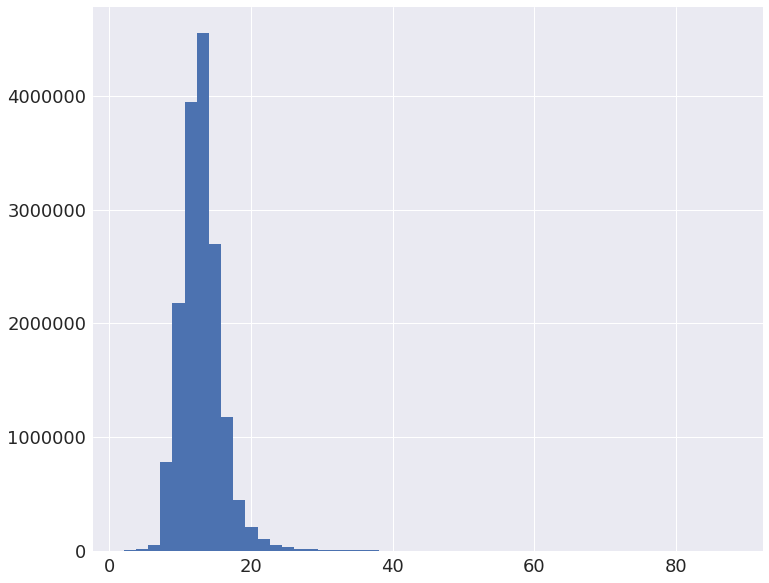

In [66]:
plot_score_hist(recommend_table)

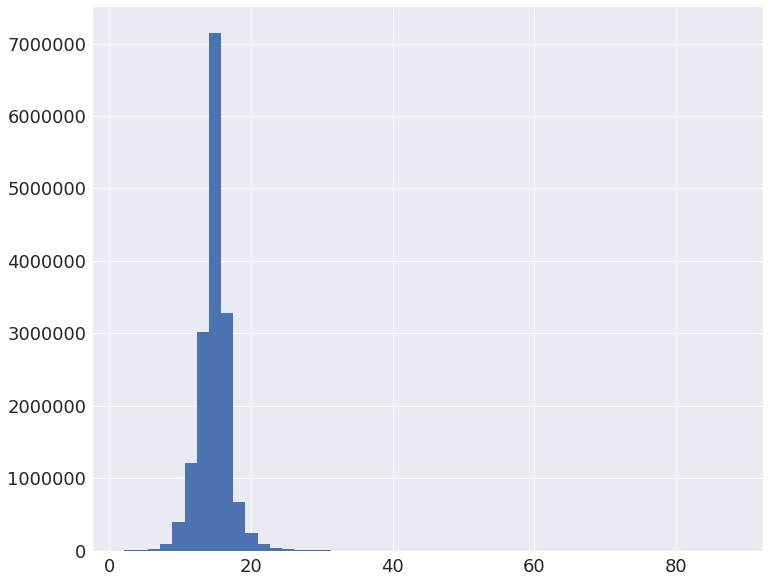

In [44]:
plot_score_hist(recommend_table)

# validation

In [45]:
sys.path.append(PROJECT_PATH)

In [46]:
sys.path

['',
 '/home/5124393/anaconda3/lib/python36.zip',
 '/home/5124393/anaconda3/lib/python3.6',
 '/home/5124393/anaconda3/lib/python3.6/lib-dynload',
 '/home/5124393/anaconda3/lib/python3.6/site-packages',
 '/home/5124393/anaconda3/lib/python3.6/site-packages/IPython/extensions',
 '/home/5124393/.ipython',
 '/home/5124393/ML_Tips/08_Recommend/']

In [47]:
import score

## test table

In [48]:
def get_test_table(category_id, recommend_table):
        # raw use log
        global target_cuid_num
#         target_cuid_num = len(df_use['cuid'].unique())
        target_cuid_num = len(df_time_context[df_time_context['genre_id']==category_id]['cuid'].unique())
        
        ##############################################
        # テストテーブルの取得
        ##############################################
        global test_table
        FILE_NAME = 'category_id_' + str(category_id) + '_test_table_201904.csv'
        test_table = pd.read_csv(os.path.join(DATA_FILE_PATH, 'test', FILE_NAME))
        
        ##############################################
        # テスト期間の状況発生履歴テーブルの取得
        ##############################################
        global test_context_count_table
        FILE_NAME = 'category_id_' + str(category_id) + '_test_context_count_table_201904.csv'
        test_context_count_table = pd.read_csv(os.path.join(DATA_FILE_PATH, 'test', FILE_NAME))
        
        global target_recommend_table
        target_recommend_table = recommend_table[recommend_table['genre_id']==category_id]

## metrics

In [49]:
def metrics_result(recommend_table, test_table, test_context_count_table, train_week_num=4, make_cond='week', is_boolean=False,  category_id=None, target_cuid_num=None, is_dservice=True):
    result_list = []
    for s_th in range(0, 30, 5):
        for k in range(1, 6):
            try:
                delivery_user, actual_delivery_user_num, auc, fpr, tpr, thresholds, true_list, scores_list, precision_list, recall_list, pr_thresholds, ave_precision, precision, recall = \
                score.model_score(recommend_table, s_th, test_table, test_context_count_table, topk=k, is_boolean=is_boolean)
                result_list.append([s_th, k, target_cuid_num, delivery_user, actual_delivery_user_num, auc, precision, recall])
            except:
                result_list.append([s_th, k, target_cuid_num, 0, 0, None, None, 0])
            
    df_result = pd.DataFrame(result_list, columns=['score_threshod', 'topk', 'user_num', 'delivery_user_num', 'actual_delivery_user_num', 'AUC', 'precision', 'recall'])
    return df_result

In [50]:
get_test_table(3, df_recommend_table)
# get_test_table(category_id, df_time_context)
##############################################
# 効果測定
##############################################
# parameter list
df_result = metrics_result(target_recommend_table,
                   test_table, 
                   test_context_count_table, 
                   is_boolean=False, 
                   category_id=category_id, 
                   target_cuid_num=target_cuid_num, 
                   is_dservice=False)

In [78]:
df_result

,score_threshod,topk,user_num,delivery_user_num,actual_delivery_user_num,AUC,precision,recall
0,0,1,1565,7082,549,0.768494,0.153253,0.022896
1,0,2,1565,7082,600,0.748296,0.131528,0.037739
2,0,3,1565,7082,660,0.740931,0.121207,0.048600
3,0,4,1565,7082,778,0.756186,0.101122,0.059944
4,0,5,1565,7082,796,0.763550,0.096294,0.064375
5,5,1,1565,7082,549,0.768494,0.153253,0.022896
6,5,2,1565,7082,600,0.748296,0.131528,0.037739
7,5,3,1565,7082,660,0.740931,0.121207,0.048600
8,5,4,1565,7082,778,0.756186,0.101122,0.059944
9,5,5,1565,7082,796,0.763550,0.096294,0.064375


上はpoitypeを数値で、下はonehotで表現。上のほうがレコメンドできているのをみると、状況の近さを考慮したほうがよさそう

In [51]:
df_result

,score_threshod,topk,user_num,delivery_user_num,actual_delivery_user_num,AUC,precision,recall
0,0,1,1565,7082,485,0.769303,0.164261,0.020549
1,0,2,1565,7082,525,0.749100,0.142655,0.033496
2,0,3,1565,7082,543,0.730325,0.138210,0.041837
3,0,4,1565,7082,550,0.724661,0.131411,0.046734
4,0,5,1565,7082,558,0.723246,0.128641,0.050130
5,5,1,1565,7082,485,0.769303,0.164261,0.020549
6,5,2,1565,7082,525,0.749100,0.142655,0.033496
7,5,3,1565,7082,543,0.730325,0.138210,0.041837
8,5,4,1565,7082,550,0.724661,0.131411,0.046734
9,5,5,1565,7082,558,0.723246,0.128641,0.050130
